In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from utils.load import load_all_inversion_results
from visualization.plots import plot_loss_topography_griddata, plot_loss_and_precipitation, plot_loss_and_temperature


In [2]:
df = load_all_inversion_results("data_E/joint_T_P")


In [3]:
df

,iter,loss,P,T
0,1,0.110,2.000,5.000
1,2,0.103,1.950,5.050
2,3,0.095,1.901,5.100
3,4,0.088,1.860,5.141
4,5,0.080,1.819,5.183
...,...,...,...,...
434,15,0.010,1.476,6.516
435,16,0.008,1.448,6.544
436,17,0.005,1.423,6.569
437,18,0.003,1.400,6.592


In [4]:
# chunks = [df.iloc[i*100:(i+1)*100] for i in range(4)]


In [5]:
# # for temperature reconstructions 

# for i, chunk in enumerate(chunks):
#     data_fidelity_history = chunk['loss'].values
#     temp_history = chunk['T'].values
#     true_temp = 7.0
#     filename = f'loss_and_precip_T{temp_history[0]}_P{chunk['P'].iloc[0]}.png'

#     plot_loss_and_temperature(
#         data_fidelity_history,
#         temp_history,
#         filename,
#         true_temp
#     )


In [6]:
# # for precipitation reconstructions
# for i, chunk in enumerate(chunks):
#     data_fidelity_history = chunk['loss'].values
#     Precip_history = chunk['P'].values
#     true_precip = 1.5
#     filename = f'loss_and_precip_T{chunk['T'].iloc[0]}_P{Precip_history[0]}.png'

#     plot_loss_and_precipitation(
#         data_fidelity_history,
#         Precip_history,
#         filename,
#         true_precip
#     )


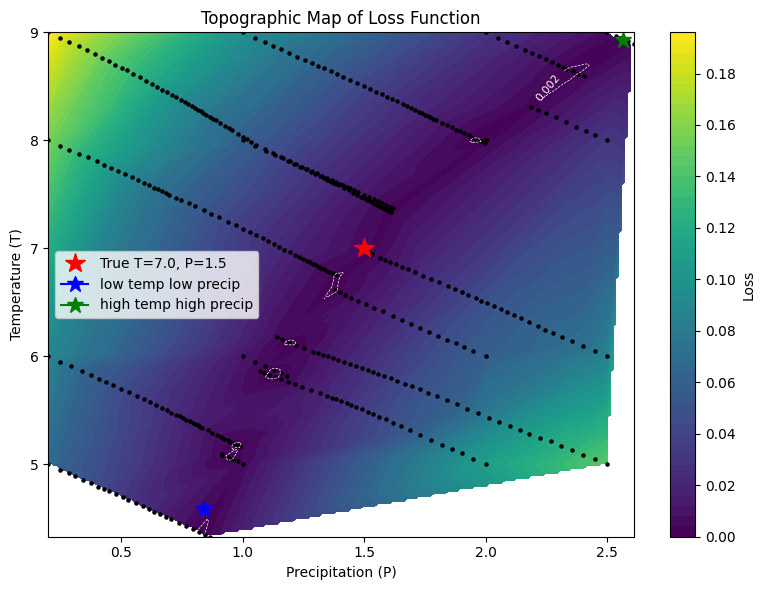

In [7]:
plot_loss_topography_griddata(df, true_P=1.5, true_T=7.0,levels=50, savepath='visualization/FIGURES/cost_topo_joint_P_T_emulator.png')


In [8]:
with open("invert_P_T.out", "r") as file:
    log_text = file.read()


FileNotFoundError: [Errno 2] No such file or directory: 'invert_P_T.out'

In [ ]:
# Split the log into separate runs
runs = re.split(r'--- Running inversion', log_text)
results = []

for run in runs:
    if not run.strip():
        continue
    
    header_match = re.search(r'T_m_lowest=(\d+\.\d+), initial_precip=(\d+\.\d+)', run)
    if not header_match:
        continue

    T_m_lowest = float(header_match.group(1))
    initial_precip = float(header_match.group(2))
    
    iterations = re.findall(r'Iter (\d+): loss=([\d.]+), precip=([\d.]+), T=([\d.]+)', run)
    
    if not iterations:
        continue
    
    final_iter, final_loss, final_precip, final_T = map(float, iterations[-1])
    
    results.append({
        'T_m_lowest': T_m_lowest,
        'initial_precip': initial_precip,
        'final_iter': int(final_iter),
        'final_precip': final_precip,
        'final_T': final_T,
        'final_loss': final_loss
    })

# Create a DataFrame
df = pd.DataFrame(results)

# Sort or pivot as needed
df = df.sort_values(['T_m_lowest', 'initial_precip'])

# Display
display(df)


In [ ]:
plt.figure(figsize=(12, 6))

# Starting points
x_start = df['initial_precip'].values
y_start = df['T_m_lowest'].values

# Direction vectors
dx = (df['final_precip'] - df['initial_precip']).values
dy = (df['final_T'] - df['T_m_lowest']).values

# Final loss values
loss = df['final_loss'].values

# Clamp color normalization to a max of 0.05
norm = Normalize(vmin=loss.min(), vmax=0.05)  # max clamped here
cmap = cm.viridis

# Plot quiver with clamped color scale
quiv = plt.quiver(x_start, y_start, dx, dy, loss, 
                  angles='xy', scale_units='xy', scale=1,
                  cmap=cmap, norm=norm, width=0.005)

# Add colorbar
cbar = plt.colorbar(quiv)
cbar.set_label("Final Loss (Clamped at 0.05)")

# Mark true value
plt.plot(1.5, 7.0, 'r*', markersize=15, label='True T=7, P=1.5')
plt.plot(df['final_precip'],df['final_T'], alpha=0.2)
# Add labels and limits
plt.title("Temperature vs Precipitation (Arrows colored by Final Loss)")
plt.xlabel("Precipitation")
plt.ylabel("Temperature")
plt.grid(True)
plt.xlim(0, max(x_start + dx) + 0.5)
plt.ylim(min(y_start), max(y_start + dy) + 1.5)
plt.legend()
plt.tight_layout()
plt.savefig("tempvsprecip.png")
plt.show()


In [ ]:
display(df)

In [ ]:
# To store all convergence curves
convergence_data = []

for run in runs:
    # Get parameters
    match = re.search(r'T_m_lowest=(\d+\.\d+), initial_precip=(\d+\.\d+)', run)
    if not match:
        continue
    
    T0 = float(match.group(1))
    P0 = float(match.group(2))
    
    # Get all iteration lines
    iter_data = re.findall(r'Iter (\d+): loss=([\d.]+)', run)
    if not iter_data:
        continue
    
    iters = [int(i) for i, _ in iter_data]
    losses = [float(l) for _, l in iter_data]
    iters.insert(0,0)
    iters.pop()
    
    convergence_data.append({
        "T0": T0,
        "P0": P0,
        "iters": iters,
        "losses": losses
    })


In [ ]:
plt.figure(figsize=(10, 6))

for run in convergence_data:
    label = f"T0={run['T0']}, P0={run['P0']}"
    plt.plot(run["iters"], run["losses"], label=label)

# plt.yscale('log')  # Use log scale for better visibility
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence of Inversions")
plt.grid(True)
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()


## Loss topography

In [ ]:
points = []

for run in runs:
    header = re.search(r'T_m_lowest=(\d+\.\d+), initial_precip=(\d+\.\d+)', run)
    if not header:
        continue  # skip if the header line doesn't match
    previous_P=float(header[2])
    previous_T=float(header[1])
    if not header:
        continue
    for match in re.finditer(r'loss=([\d.]+), precip=([\d.]+), T=([\d.]+)', run):
        loss, P, T = map(float, match.groups())
        points.append((previous_P, previous_T, loss))
        previous_P, previous_T=P,T

In [ ]:
points = np.array(points)
P_vals = points[:, 0]
T_vals = points[:, 1]
loss_vals = points[:, 2]


# Define grid
P_grid = np.linspace(P_vals.min(), P_vals.max(), 200)
T_grid = np.linspace(T_vals.min(), T_vals.max(), 200)
P_mesh, T_mesh = np.meshgrid(P_grid, T_grid)

# Interpolate
Z = griddata(points[:, :2], loss_vals, (P_mesh, T_mesh), method='cubic')



In [ ]:
plt.figure(figsize=(10, 8))

# Contourf with color
contour = plt.contourf(P_mesh, T_mesh, Z, levels=100, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label("Loss")

# Overlay original points
plt.scatter(P_vals, T_vals, c='red', s=10, label='Sampled Points')

# Optional: True T and P
plt.plot(1.5, 7.0, 'r*', markersize=15, label='True T=7, P=1.5')

plt.xlabel("Precipitation")
plt.ylabel("Temperature")
plt.title("Loss Topography")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('data/cost_topo1.png')
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))

# Overlay original points
plt.scatter(T_vals, loss_vals,s=5, label='Sampled Points')

# Optional: True T and P
# plt.plot(1.5, 7.0, 'r*', markersize=15, label='True T=7, P=1.5')

plt.xlabel("Precipitation")
plt.ylabel("Loss vlue")
plt.title("Loss Topography")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
